# BIKE SHARING DEMAND

### ABSTRACT

- The aim of this assignment is to get a minimum value of the error term which in this case is the root mean square logarithmic error.


- This is done by testing various Data Science models by doing feature scaling, parameter tuning, ensemble modeling, etc.


- A RMSLE value of 0.396 is achieved at the end of this experiment.

### DESCRIPTION

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

### ACKNOWLEDGEMENT

Kaggle hosted this competition for the machine learning community to use for fun and practice. This dataset was provided by Hadi Fanaee Tork using data from Capital Bikeshare. Kaggle also thanks the UCI machine learning repository for hosting the dataset. 

### DATA

1. datetime : hourly date + timestamp
2. season : 1 - Spring, 2 - Summer, 3 - Fall, 4 - Winter
3. holiday : weather the day is consider a holiday, 
4. weather :  1 - Clear, Few clouds, Partly cloudy, Partly cloudy, 2 - Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist, 3 - Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds, 4 - Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
5. temp : temperature in Celcius
6. atemp : feels like temperature in Celcius
7. humidity : relative humidity
8. windspeed : speed of the wind
9. casual : number of non registered user rentals initiated
10. registered : number of registered user rentals initiated
11. count : total number of rentals (casual + registered) 

$Target$ $Variable$ = Count 

### EXPLORATORY DATA ANALYSIS

In [1]:
%matplotlib inline 
import pylab
import calendar
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime
import seaborn as sns
import warnings
import re
from sklearn import metrics
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression,LogisticRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor as tree
from sklearn import ensemble

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import statistics as st
import statsmodels.api as sm
#evaluation metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score  # for classification

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
df_train.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
df_test.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [5]:
print("Null values in Training Set: ",df_train.isnull().sum()[df_train.isnull().sum() != 0])
print("Null values in Testing Set: ",df_test.isnull().sum()[df_train.isnull().sum() != 0])

Null values in Training Set:  Series([], dtype: int64)
Null values in Testing Set:  Series([], dtype: int64)


### CORRELATION MATRIX

Without the categorical variables

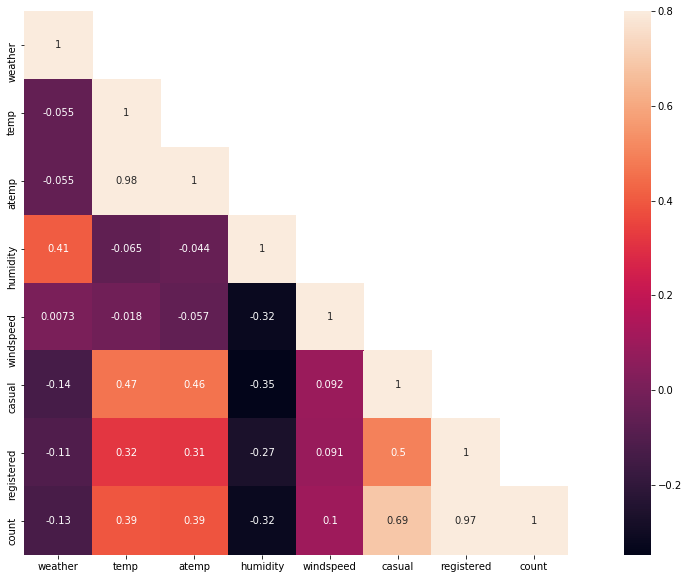

In [6]:
corrMatt = df_train[["weather","temp","atemp","humidity","windspeed","casual","registered","count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

We can see that, count has the highest negative correlation with humidity and the highest positive relation with registered which is obvious since count = casual + registered.
The second best correlation with count is of temp and atemp.  
We'll observe the correlation matrix similarly, after encoding all the categorical varibles.

##### CREATING DUMMY VARIABLES FOR SEASON AND WEATHER FOR TRAINING AND TESTING SETS

In [7]:
season=pd.get_dummies(df_train['season'],prefix='season')
weather=pd.get_dummies(df_train['weather'],prefix='weather')
df_train=pd.concat([df_train,season,weather],axis=1)
df_train.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,0,0,0,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,0,0,0,1,0,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,0,0,0,1,0,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,0,0,0,1,0,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,0,0,0,1,0,0,0


In [8]:
season=pd.get_dummies(df_test['season'],prefix='season')
weather=pd.get_dummies(df_test['weather'],prefix='weather')
df_test=pd.concat([df_test,season,weather],axis=1)
df_test.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,1,0,0,0,1,0,0,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0


##### SPLITTING THE DATETIME VARIABLE INTO HOUR, DAY, MONTH, YEAR

In [9]:
df_train["hour"] = [t.hour for t in pd.DatetimeIndex(df_train.datetime)]
df_train["day"] = [t.dayofweek for t in pd.DatetimeIndex(df_train.datetime)]
df_train["month"] = [t.month for t in pd.DatetimeIndex(df_train.datetime)]
df_train['year'] = [t.year for t in pd.DatetimeIndex(df_train.datetime)]
df_train['year'] = df_train['year'].map({2011:0, 2012:1})

df_test["hour"] = [t.hour for t in pd.DatetimeIndex(df_test.datetime)]
df_test["day"] = [t.dayofweek for t in pd.DatetimeIndex(df_test.datetime)]
df_test["month"] = [t.month for t in pd.DatetimeIndex(df_test.datetime)]
df_test['year'] = [t.year for t in pd.DatetimeIndex(df_test.datetime)]
df_test['year'] = df_test['year'].map({2011:0, 2012:1})

In [10]:
df_train.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,season_3,season_4,weather_1,weather_2,weather_3,weather_4,hour,day,month,year
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,...,0,0,1,0,0,0,0,5,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,...,0,0,1,0,0,0,1,5,1,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,...,0,0,1,0,0,0,2,5,1,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,...,0,0,1,0,0,0,3,5,1,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,...,0,0,1,0,0,0,4,5,1,0


##### PLOTTING THE BOX PLOT AND CHECKING FOR OUTLIERS

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

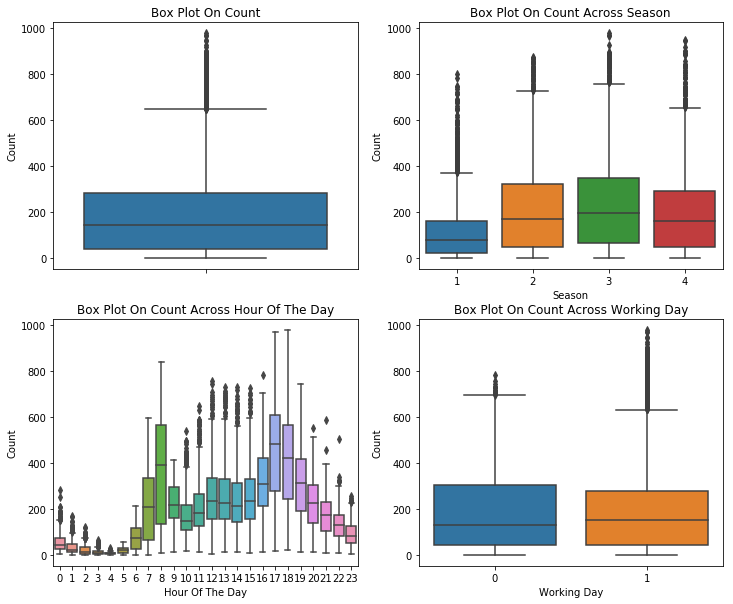

In [11]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=df_train,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=df_train,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=df_train,y="count",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=df_train,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

In [12]:
dailyDataWithoutOutliers = df_train[np.abs(df_train["count"]-df_train["count"].mean())<=(3*df_train["count"].std())] 
print ("Shape Of The Before Ouliers: ",df_train.shape)
print ("Shape Of The After Ouliers: ",dailyDataWithoutOutliers.shape)

Shape Of The Before Ouliers:  (10886, 24)
Shape Of The After Ouliers:  (10739, 24)


There are total 147 outliers in the data.

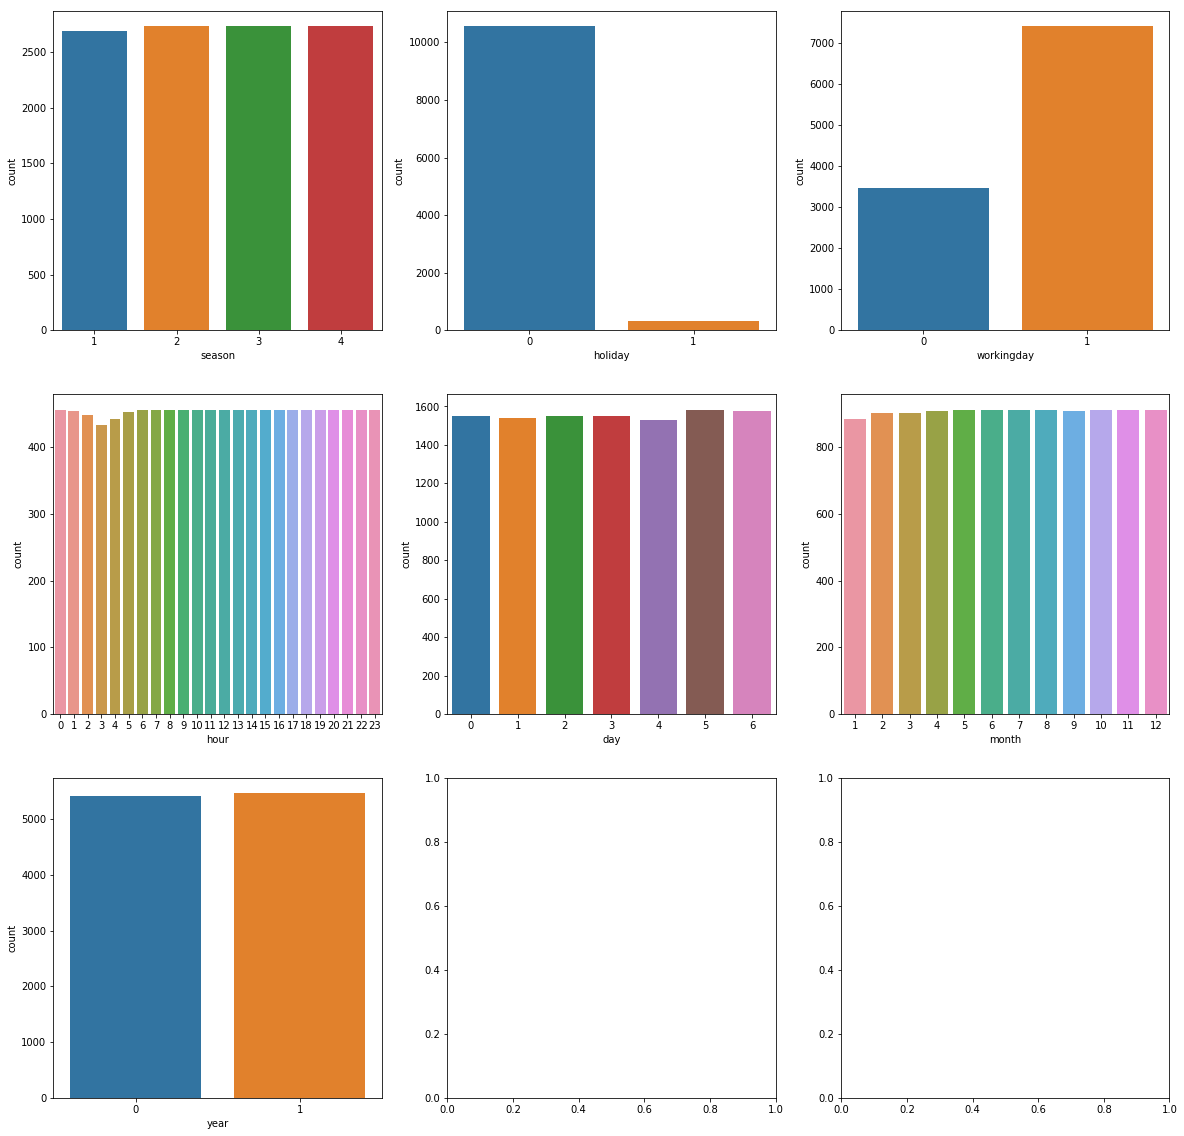

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,20))

def plotCountPlot(Name, num1, num2):
    sns.countplot(df_train[Name],ax=ax[num1][num2])

plotCountPlot('season',0,0)
plotCountPlot('holiday',0,1)
plotCountPlot('workingday',0,2)
plotCountPlot('hour',1,0)
plotCountPlot('day',1,1)
plotCountPlot('month',1,2)
plotCountPlot('year',2,0)

The number of times each variable has occured in the data can be observed from the count plot.

[Text(0, 0.5, 'Users Count'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across User Type'),
 None]

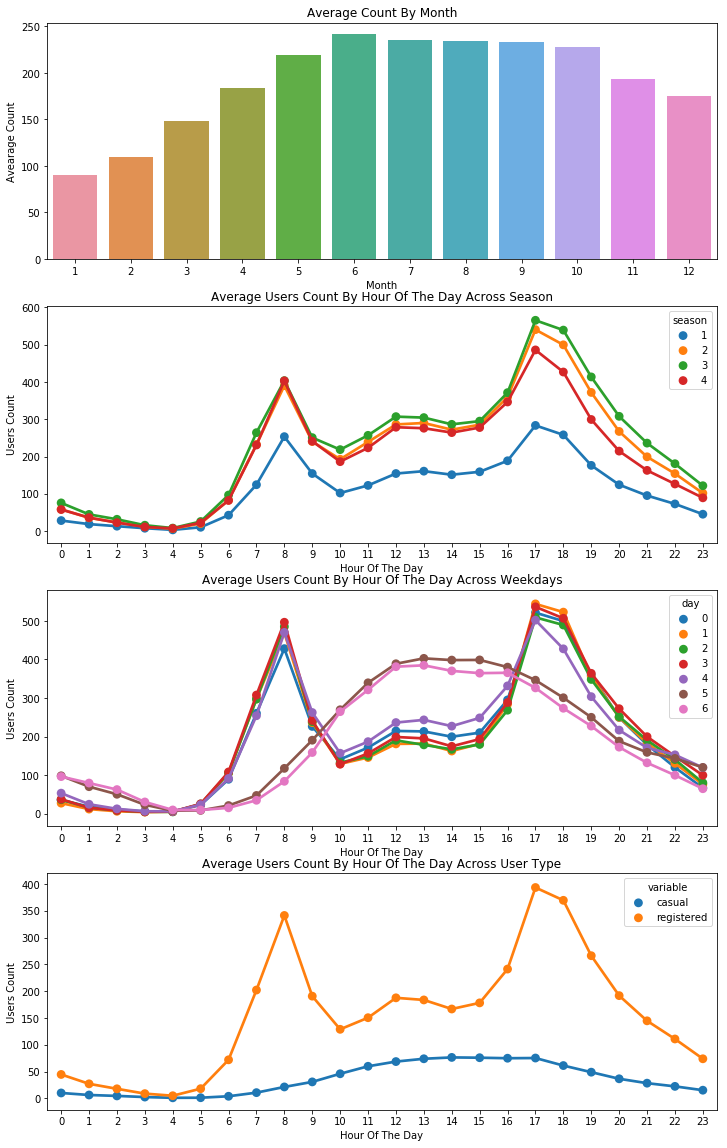

In [14]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(12,20)
sortOrder = [1,2,3,4,5,6,7,8,9,10,11,12]
hueOrder = [0,1,2,3,4,5,6]

monthAggregated = pd.DataFrame(df_train.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sns.barplot(data=monthSorted,x="month",y="count",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(df_train.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(df_train.groupby(["hour","day"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["day"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

hourTransformed = pd.melt(df_train[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')

### Visualizing Count Vs (Season, Hour, Casual & Registered)


- It is quiet obvious that people tend to rent bike during summer season since it is really conducive to ride bike at that season.Therefore June, July and August has got relatively higher demand for bicycle.


- On weekdays more people tend to rent bicycle around 7AM-8AM and 5PM-6PM. As we mentioned earlier this can be attributed to regular school and office commuters.


- Above pattern is not observed on "Saturday" and "Sunday".More people tend to rent bicycle between 10AM and 4PM.


- The peak user count around 7AM-8AM and 5PM-6PM is purely contributed by registered user.

In [15]:
df_test.drop('datetime',axis=1,inplace=True)
df_test.drop('season',axis=1,inplace=True)
df_test.drop('weather',axis=1,inplace=True)
df_test.head(5)

,holiday,workingday,temp,atemp,humidity,windspeed,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4,hour,day,month,year
0,0,1,10.66,11.365,56,26.0027,1,0,0,0,1,0,0,0,0,3,1,0
1,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,1,3,1,0
2,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,2,3,1,0
3,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,3,3,1,0
4,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,4,3,1,0


In [16]:
df_test.drop('season_4',axis=1,inplace=True)
df_test.head(5)

,holiday,workingday,temp,atemp,humidity,windspeed,season_1,season_2,season_3,weather_1,weather_2,weather_3,weather_4,hour,day,month,year
0,0,1,10.66,11.365,56,26.0027,1,0,0,1,0,0,0,0,3,1,0
1,0,1,10.66,13.635,56,0.0000,1,0,0,1,0,0,0,1,3,1,0
2,0,1,10.66,13.635,56,0.0000,1,0,0,1,0,0,0,2,3,1,0
3,0,1,10.66,12.880,56,11.0014,1,0,0,1,0,0,0,3,3,1,0
4,0,1,10.66,12.880,56,11.0014,1,0,0,1,0,0,0,4,3,1,0


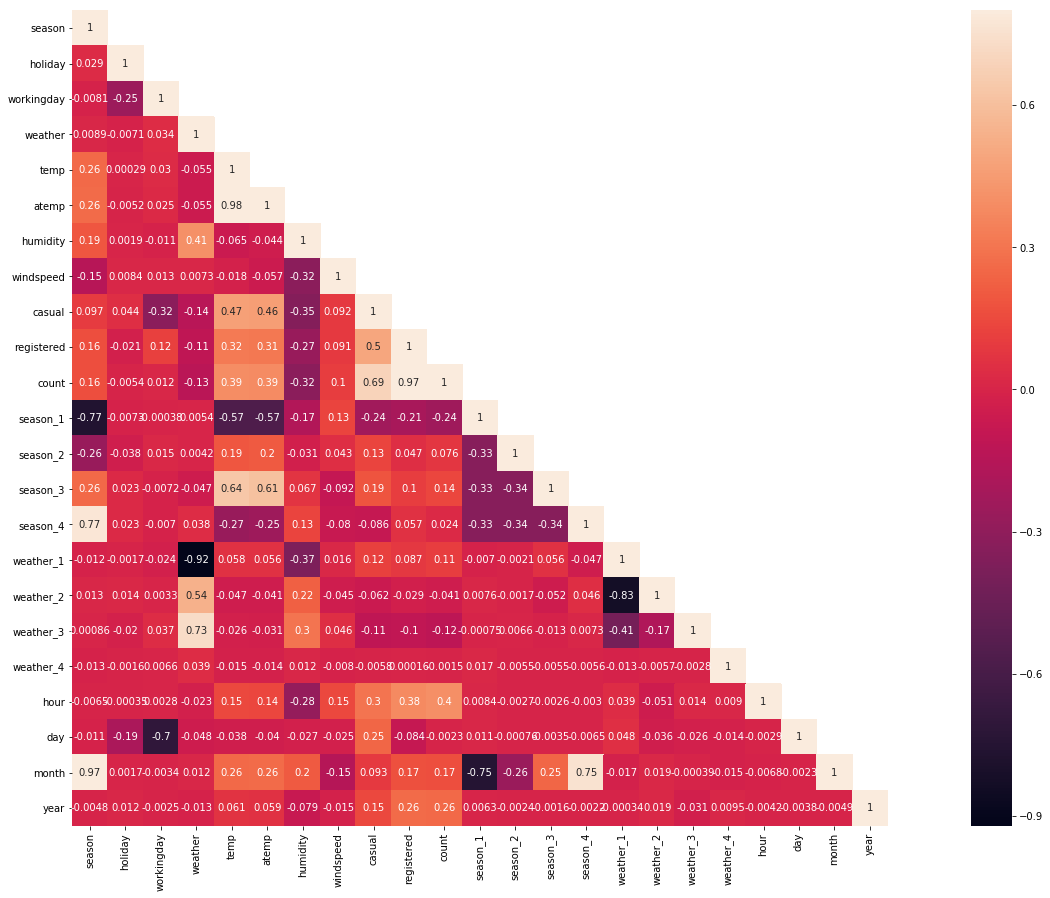

In [17]:
corrMatt = df_train[:].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(30,15)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

##### The correlation matrix is plotted again after converting all the categorical colums to numerical entries and after splitting the datetime column into hour, day, month, year.

Observations made from the correlation matrix:
1. Count has the highest correlation with the hour of the day, the second best correlation is with humidity and temp.
2. Windspeed and count has the least relation
3. Temp and atemp show high correlation with each and therefore exhibit multicollinearity, hence must be dropped during model building.

##### Plotting the regplot for the terms with the highest and lowest correlation

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


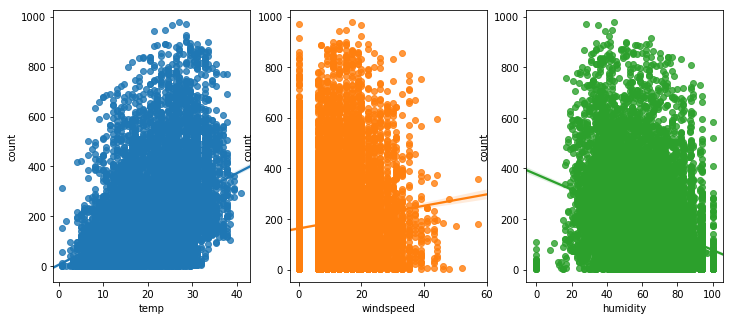

In [18]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.regplot(x="temp", y="count", data=df_train,ax=ax1)
sns.regplot(x="windspeed", y="count", data=df_train,ax=ax2)
sns.regplot(x="humidity", y="count", data=df_train,ax=ax3)

The resulting regplot for temp, windspeed and humidity suggests that the simple linear regression model does not give a good fit for the model. There are some higher order relationships present therefore, using polynomial regression model or something similar to that we can improve the fit of the model.

#### VISUALIZING DISTRIBUTION OF DATA

((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229776, 4.562423868087808, 0.9581176780909612))

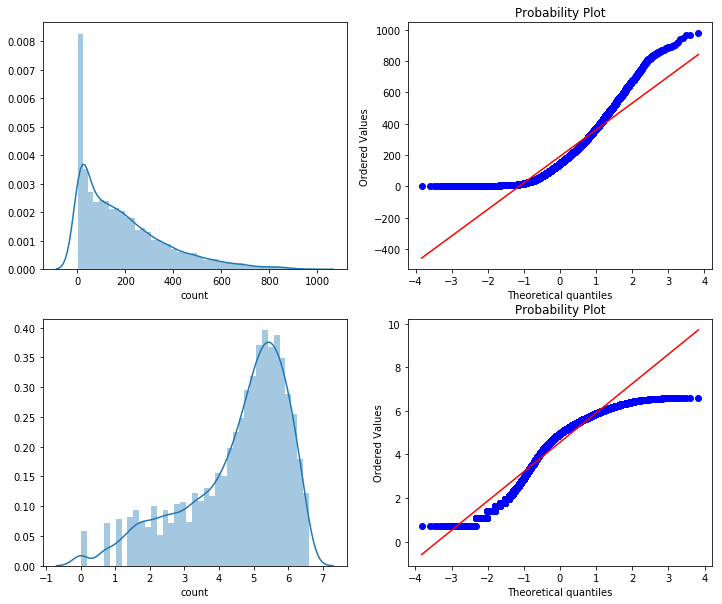

In [19]:
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sns.distplot(df_train["count"],ax=axes[0][0])
stats.probplot(df_train["count"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(dailyDataWithoutOutliers["count"]),ax=axes[1][0])
stats.probplot(np.log1p(dailyDataWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])

As it is visible from the above figures that "count" variable is skewed towards right. It is desirable to have Normal distribution as most of the machine learning techniques require dependent variable to be Normal. One possible solution is to take log transformation on "count" variable after removing outlier data points. After the transformation the data looks lot better but still not ideally following normal distribution.

### DATA MODELING

In [20]:
dataTrain = pd.read_csv("train.csv")
dataTest = pd.read_csv("test.csv")

Splitting the datetime variable to day of week, month, week, hour, year and day.

In [21]:
dataTrain['datetime'] = pd.to_datetime(dataTrain['datetime'])
dataTrain['dow'] = dataTrain['datetime'].dt.dayofweek
dataTrain['month'] = dataTrain['datetime'].dt.month
dataTrain['week'] = dataTrain['datetime'].dt.week
dataTrain['hour'] = dataTrain['datetime'].dt.hour
dataTrain['year'] = dataTrain['datetime'].dt.year
dataTrain['day'] = dataTrain['datetime'].dt.day
#dataTrain = dataTrain.set_index(dataTrain['datetime'])
dataTrain = dataTrain.drop(labels='datetime', axis=1)
dataTrain = dataTrain.drop(labels='atemp', axis=1)
dataTrain = pd.get_dummies(dataTrain, columns=['weather'])
dataTrain = dataTrain.drop(labels='weather_4', axis=1)
dataTrain = dataTrain.drop(labels='casual',axis=1)
dataTrain = dataTrain.drop(labels='registered',axis=1)

##### INTERACTION

In [22]:
dataTrain['temp_weath_1'] = dataTrain['temp'] * dataTrain['weather_1']
dataTrain['temp_weath_2'] = dataTrain['temp'] * dataTrain['weather_2']
dataTrain['temp_weath_3'] = dataTrain['temp'] * dataTrain['weather_3']

In [23]:
dataTrain['temp_weath_1'] = dataTrain['temp_weath_1'].astype(int)
dataTrain['temp_weath_2'] = dataTrain['temp_weath_2'].astype(int)
dataTrain['temp_weath_3'] = dataTrain['temp_weath_3'].astype(int)

In [24]:
X = dataTrain.loc[:, dataTrain.columns != 'count']
y = np.log(dataTrain['count'])

In order to calculate the Root Mean Square Logarithmic Value we'll have to consider the logarithmic value of the target variable which is count in this case.

Splitting the training and testing data keeping the test size of 0.2

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

Splitting the datetime column from the testing set to day of week, month, week, hour, year and day.

In [26]:
dataTest['datetime'] = pd.to_datetime(dataTest['datetime'])
dataTest['dow'] = dataTest['datetime'].dt.dayofweek
dataTest['month'] = dataTest['datetime'].dt.month
dataTest['week'] = dataTest['datetime'].dt.week
dataTest['hour'] = dataTest['datetime'].dt.hour
dataTest['year'] = dataTest['datetime'].dt.year
dataTest['day'] = dataTest['datetime'].dt.day
#dataTest = dataTest.set_index(dataTest['datetime'])
dataTest = dataTest.drop(labels='datetime', axis=1)
dataTest = dataTest.drop(labels='atemp', axis=1)
dataTest = pd.get_dummies(dataTest, columns=['weather'])
dataTest = dataTest.drop(labels='weather_4', axis=1)

##### INTERACTION DONE IN TESTING SET 

In [27]:
dataTest['temp_weath_1'] = (dataTest['temp'] * dataTest['weather_1']).astype(int)
dataTest['temp_weath_2'] = (dataTest['temp'] * dataTest['weather_2']).astype(int)
dataTest['temp_weath_3'] = (dataTest['temp'] * dataTest['weather_3']).astype(int)

In [28]:
X.head(5)

,season,holiday,workingday,temp,humidity,windspeed,dow,month,week,hour,year,day,weather_1,weather_2,weather_3,temp_weath_1,temp_weath_2,temp_weath_3
0,1,0,0,9.84,81,0.0,5,1,52,0,2011,1,1,0,0,9,0,0
1,1,0,0,9.02,80,0.0,5,1,52,1,2011,1,1,0,0,9,0,0
2,1,0,0,9.02,80,0.0,5,1,52,2,2011,1,1,0,0,9,0,0
3,1,0,0,9.84,75,0.0,5,1,52,3,2011,1,1,0,0,9,0,0
4,1,0,0,9.84,75,0.0,5,1,52,4,2011,1,1,0,0,9,0,0


In [29]:
dataTest.head(5)

,season,holiday,workingday,temp,humidity,windspeed,dow,month,week,hour,year,day,weather_1,weather_2,weather_3,temp_weath_1,temp_weath_2,temp_weath_3
0,1,0,1,10.66,56,26.0027,3,1,3,0,2011,20,1,0,0,10,0,0
1,1,0,1,10.66,56,0.0000,3,1,3,1,2011,20,1,0,0,10,0,0
2,1,0,1,10.66,56,0.0000,3,1,3,2,2011,20,1,0,0,10,0,0
3,1,0,1,10.66,56,11.0014,3,1,3,3,2011,20,1,0,0,10,0,0
4,1,0,1,10.66,56,11.0014,3,1,3,4,2011,20,1,0,0,10,0,0


#### OBSERVING MODEL FITS BY USING DIFFERENT MODELS

Performing hyperparameter tuning for Random Forest Regressor and finding the best hyperparameters for the same.

In [31]:
param_grid = {'n_estimators': [1000,2000,3000],
              'max_depth': [10, 15, 20],
              'min_samples_leaf': [5, 10, 20],
              }
est = ensemble.RandomForestRegressor(n_estimators=500)
gs_cv = GridSearchCV(est, param_grid, n_jobs=4).fit(X_train, y_train)
gs_cv.best_params_

/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A

{'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 3000}

In [35]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=3000, max_depth=20, min_samples_leaf=5)
rfModel.fit(X_train,y_train)
pred_rfr = rfModel.predict(X=dataTest)
pred_rfr

array([2.52670109, 1.61066008, 1.28157811, ..., 4.73821296, 4.51382615,
       4.14234029])

Similarly, performing hyperparameter tuning for Gradient Boost Regressor and finding the best hyperparameters for the same.

In [37]:
param_grid = {'n_estimators': [1000,2000,4000],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [10, 15, 20],
              'min_samples_leaf': [5, 10, 20],
              }
est = ensemble.GradientBoostingRegressor(n_estimators=500)
gs_cv = GridSearchCV(est, param_grid, n_jobs=4).fit(X_train, y_train)
gs_cv.best_params_

/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A

{'learning_rate': 0.01,
 'max_depth': 10,
 'min_samples_leaf': 20,
 'n_estimators': 1000}

In [38]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000,alpha=0.01, max_depth=10, min_samples_leaf=20)
gbm.fit(X_train,y_train)
predsTest = gbm.predict(X= dataTest)
predsTest

array([2.49005627, 1.66123566, 1.26871414, ..., 4.88364995, 4.57254289,
       3.98890768])

In [39]:
y_predgbr = np.exp(predsTest)
y_predgbr

array([ 12.06195484,   5.26581359,   3.55627675, ..., 132.1119868 ,
        96.78992292,  53.99587613])

Hyperparameter tuning by using GridSearchCV for XGBoost Model

In [40]:
param_grid = { 
    'n_estimators': [1000,2000,3000,4000],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [7, 10, 15, 20],
}

In [42]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
xgb = XGBRegressor()
gs_cv = GridSearchCV(xgb, param_grid, n_jobs=4).fit(X_train, y_train)
gs_cv.best_params_

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while

{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 2000}

In [91]:
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
standardscaler = StandardScaler()
xgb = XGBRegressor(n_thread=4, colsample_bytree=0.7, learning_rate=0.01, n_estimators=2000, max_depth=7, min_child_weight=4, subsample=0.7, random_state=42)
xgb.fit(X_train, y_train)
xgb.predict(dataTest)

array([2.7297308, 1.540576 , 1.3756021, ..., 4.80318  , 4.4685264,
       3.9215689], dtype=float32)

Pipeline class allows fitting multiple processes in a single scikit-learn estimator.

StandardScaler subtracts the mean from each features and then scale to unit variance.

Polynomial Featuring imports the model to a higher dimension to provide a better fit. For example if the input model is 2-dimensional of the form [a,b], then the degree 2 polynomial features will be [1,a,b,a^2,b^2,ab]

In [92]:
from sklearn.pipeline import Pipeline, make_pipeline
pipe = Pipeline([('poly', PolynomialFeatures()),('StandardScaler',standardscaler),('XGB',xgb)])

In [93]:
pipe.fit(X_train, y_train)
y_pred = np.exp(pipe.predict(dataTest))
y_pred

array([ 14.574541 ,   5.0492196,   3.7262185, ..., 137.45125  ,
        99.02447  ,  54.479355 ], dtype=float32)

XG Boost Model gives an RMSLE of 0.396

In [46]:
pipe = Pipeline([('poly', PolynomialFeatures()),('StandardScaler',standardscaler),('RFR', rfModel)])
pipe.fit(X_train, y_train)
y_pred1 = np.exp(pipe.predict(dataTest))
y_pred1

array([ 15.82234879,   5.39079329,   3.69705697, ..., 155.81880786,
       105.24518957,  65.96984388])

Random Forest Regressor gives an RMSLE of 0.41815

In [47]:
datetimecol = pd.read_csv("test.csv")
datetimecol = datetimecol["datetime"]

In [48]:
pipe = Pipeline([('poly', PolynomialFeatures()),('StandardScaler',standardscaler),('GBM', gbm)])
pipe.fit(X_train, y_train)
y_pred2 = np.exp(pipe.predict(dataTest))
y_pred2

array([ 17.95593465,   4.49316552,   3.58653943, ..., 144.00638485,
       107.98066279,  52.13938646])

In [49]:
from sklearn.ensemble import BaggingRegressor
model = BaggingRegressor(tree(random_state=1))
model.fit(X_train, y_train)
m = model.predict(dataTest)
np.exp(m)

array([ 13.07727282,   4.15426965,   4.14726445, ..., 105.71871974,
        92.63746331,  54.75260335])

In [50]:
pipe = Pipeline([('poly', PolynomialFeatures()),('StandardScaler',standardscaler),('Bagging', model)])
pipe.fit(X_train, y_train)
y_pred3 = np.exp(pipe.predict(dataTest))
y_pred3

array([ 19.14116421,   5.28530959,   5.90572268, ..., 144.77979081,
        88.4690902 ,  51.25312721])

RMSLE value of 0.43087

y_pred that is predictions from XGBoost Regressor are used since it gives the lowest RMSLE value.

In [94]:
submission = pd.DataFrame({
        "datetime": datetimecol,
        "count": [max(0, x) for x in y_pred]
    })
submission.to_csv('Submission.csv', index=False)

## CONCLUSION 

- Feature Engineering plays an important role in getting a better Model Accuracy. In this problem, I have removed the Multicollinearity term of atemp as it had very high correlation with temp term and performed interaction on Temperature and Weather terms of the data.


- By doing hyperparameter tuning using GridSearchCV I have found the best value for the Root Mean Square Logarithmic Error (RMSLE) of 0.399 and secured a rank of 250 in the public leaderboard that is top 7%. 


- I further pipelined the model and improved the RMSLE value to 0.396 and secured a rank of 196 on the leaderboard that is top 6%.

## CONTRIBUTIONS

Personal Contribution : 40%

External Source : 60%

## CITATIONS

1. Article title:	EDA & Ensemble Model (Top 10 Percentile) | Kaggle

   Website title:	Kaggle.com
   
   URL          :	https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile
   
   
2. Article title:	Bike Sharing Demand | Kaggle

   Website title:	Kaggle.com
   
   URL          :	https://www.kaggle.com/c/bike-sharing-demand
   
   
3. Article title:	A Simple Example of Pipeline in Machine Learning with Scikit-learn

   Website title:	Towards Data Science
   
   URL          :	https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976
   
   
4. Article title:	Forecasting Bike Sharing Demand – EFavDB

   Website title:	Efavdb.com
   
   URL:	http://efavdb.com/bike-share-forecasting/
   
   
5. Article title:	A Simple Example of Pipeline in Machine Learning with Scikit-learn

   Website title:	Towards Data Science
   
   URL          :	https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976
   

6. Article title:	sklearn.preprocessing.PolynomialFeatures — scikit-learn 0.20.3 documentation

   Website title:	Scikit-learn.org
   
   URL          :	https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

## LICENSE

Copyright 2019 APURVA PRAVIN SALVI

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.